# Tutorial 4: tuning parameters for iDDN

This tutorial shows how to tune the two hyperparameters using data driven cross validation based methods.
Our approach is to first search for $\lambda_1$, then based on the chosen value of $\lambda_1$ to search for $\lambda_2$.

Although we also provide functions to jointly search $\lambda_1$ and $\lambda_2$ on a grid, due to computational reason, it is often not efficient when the network is large, so we will not discuss this option here. However, as you will see, it is straightforward to do that if desired. In addition, we also provide methods purely based on statistic and probability theory, which is very easy to calculate, but may not always be accurate enough. We will briefly talk about it.

Again, it is important to note that the best choice of $\lambda_1$ and $\lambda_2$ often relies on domain knowledge. 
Those provided by cross validation may not reflect the underlying biological process. 
Therefore, we advise user to choose a range of parameters and plot networks to choose good parameters.

Compared with the similar tutorial in the DDN3.0 package, now we 1) support iDDN (multi-omics with constraints), 2) support parallel computing for cross validation, and 3) include some tricks to handle large problems.

We first import the necessary modules.


In [1]:
import numpy as np
from iddn_data import load_data  # Load example data and images
from iddn import parameter_tuning_iddn as parameter_tuning  # parameter tuning tools

%load_ext autoreload
%autoreload 2

We load the data.

We use the same example as before. The parameter tuning supports parallel computing.
As our example is small, one core (`cores=1`) is good enough. Using multiple core will not have clear benefits here. 

In [2]:
example = load_data.load_example()
dat1 = example["dat1"]
dat2 = example["dat2"]
dep_mat = example["dep_mat"]

cores = 1

## Step 1: search $\lambda_1$ using cross validation

We first keep $\lambda_2$ fixed and scan $\lambda_1$ to find the optimal value using cross validation.
This allows us to efficiently work on larger networks (compared to using grid search for two parameters).

Specifically, for each $\lambda_1$, certain part (`ratio_val`) of the data (training set) is used to estimate the networks, and then for each node, the regression coefficients are calculated to use the values of all other nodes to estimate the value of this node.
These regression models are then applied on the remaining part of the data (test set) to estimate each node using all other nodes, and we calculate the unexplained variance as the error measure.

Therefore, we have an error value for each $\lambda_1$. Since we repeat the cross validation for several time (`n_cv`), we have an associated standard error. This allows us to pick the optimal $\lambda_1$, and optionally considers the uncertainty of estimation.

Here we keep the $\lambda_2$ value as 0.05, which is a typical value used in many cases.
We search $\lambda_1$ from 0.02 to 0.4, with a step size of 0.02.


In [3]:
l1_list = np.arange(0.02, 0.401, 0.02)

Here we call the cross validation function. This function actually allows doing grid search if we input a list of $\lambda_1$ as well as a list of $\lambda_2$. We need to specify 
- `dat1` and `dat2`: the input data
- `n_cv`: the repeats for cross validation
- `ratio_val`: the ratio of data left out for validation (0.5 means 50%)
- `lambda1_lst` and `lambda2_lst`: the list of parameters to search
- `dep_mat`: the constraint matrix of iDDN
- `cores`: the number of cores to use

In [4]:
val_err_l1 = parameter_tuning.cv_2d(
    dat1,
    dat2,
    n_cv=5,
    ratio_val=0.5, 
    lambda1_lst=l1_list,
    lambda2_lst=[0.05],
    dep_mat=dep_mat,
    cores=cores,
)

0 0.02 0.05 s0
0 0.04 0.05 s0
0 0.06 0.05 s0
0 0.08 0.05 s0
0 0.1 0.05 s0
0 0.12000000000000001 0.05 s0
0 0.13999999999999999 0.05 s0
0 0.16 0.05 s0
0 0.18 0.05 s0
0 0.19999999999999998 0.05 s0
0 0.22 0.05 s0
0 0.24 0.05 s0
0 0.26 0.05 s0
0 0.28 0.05 s0
0 0.30000000000000004 0.05 s0
0 0.32 0.05 s0
0 0.34 0.05 s0
0 0.36000000000000004 0.05 s0
0 0.38 0.05 s0
0 0.4 0.05 s0
1 0.02 0.05 s0
1 0.04 0.05 s0
1 0.06 0.05 s0
1 0.08 0.05 s0
1 0.1 0.05 s0
1 0.12000000000000001 0.05 s0
1 0.13999999999999999 0.05 s0
1 0.16 0.05 s0
1 0.18 0.05 s0
1 0.19999999999999998 0.05 s0
1 0.22 0.05 s0
1 0.24 0.05 s0
1 0.26 0.05 s0
1 0.28 0.05 s0
1 0.30000000000000004 0.05 s0
1 0.32 0.05 s0
1 0.34 0.05 s0
1 0.36000000000000004 0.05 s0
1 0.38 0.05 s0
1 0.4 0.05 s0
2 0.02 0.05 s0
2 0.04 0.05 s0
2 0.06 0.05 s0
2 0.08 0.05 s0
2 0.1 0.05 s0
2 0.12000000000000001 0.05 s0
2 0.13999999999999999 0.05 s0
2 0.16 0.05 s0
2 0.18 0.05 s0
2 0.19999999999999998 0.05 s0
2 0.22 0.05 s0
2 0.24 0.05 s0
2 0.26 0.05 s0
2 0.28 0.05 s0


The output (val_err_l1) is of shape (repeats of CV, number of lambda1, number of lambda2), and each element is the unexplained variance in the validation set.
We can plot the curve with respect to the $\lambda_1$ values. Here we need to `squeeze()` the `val_err_l1`, as the drawing function need the input to have shape (repeats of CV, number of lambda1 or lambda2).

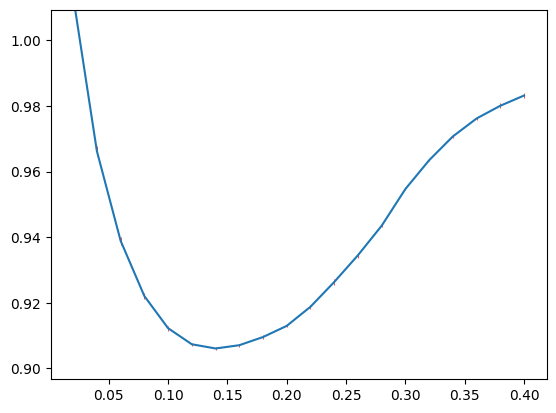

In [5]:
# val_avg = np.mean(val_err_l1_1, axis=0)
# val_std = np.std(val_err_l1_1, axis=0)
parameter_tuning.plot_error_1d(val_err_l1.squeeze(), lambda_lst=l1_list)

As we can see, it is good to choose $\lambda_1$ around 0.15.

In [6]:
val_avg = np.mean(val_err_l1, axis=0)
l1_est = l1_list[np.argmin(val_avg)]
print(l1_est)

0.13999999999999999


We use the one-standard error rule, which gives 0.16. 

In [7]:
parameter_tuning.get_lambda_one_se_1d(val_err_l1.squeeze(), l1_list)

0.16

Also note that, if the data is large (especially node size), we may wish to divide the search to two parts.
First, we can search a wider range of $\lambda_1$ with large step size.
After we roughly know the range of good $\lambda_1$ value, we can use a smaller range and finer step size.

## Step 2: search $\lambda_2$ using cross validation

We now search $\lambda_2$ with $\lambda_1$ fixed to be 0.15. The code is almost the same as the previous one.
Usally, we do not need to search for too large $\lambda_2$, and here an upper bound of 0.16 is sufficient.

In [8]:
l2_list = np.arange(0.01, 0.16, 0.01)

In [9]:
val_err_l2 = parameter_tuning.cv_2d(
    dat1,
    dat2,
    n_cv=5,
    ratio_val=0.5, 
    lambda1_lst=[0.15],
    lambda2_lst=l2_list,
    dep_mat=dep_mat,
    cores=cores,
)

0 0.15 0.01 s0
0 0.15 0.02 s0
0 0.15 0.03 s0
0 0.15 0.04 s0
0 0.15 0.05 s0
0 0.15 0.060000000000000005 s0
0 0.15 0.06999999999999999 s0
0 0.15 0.08 s0
0 0.15 0.09 s0
0 0.15 0.09999999999999999 s0
0 0.15 0.11 s0
0 0.15 0.12 s0
0 0.15 0.13 s0
0 0.15 0.14 s0
0 0.15 0.15000000000000002 s0
1 0.15 0.01 s0
1 0.15 0.02 s0
1 0.15 0.03 s0
1 0.15 0.04 s0
1 0.15 0.05 s0
1 0.15 0.060000000000000005 s0
1 0.15 0.06999999999999999 s0
1 0.15 0.08 s0
1 0.15 0.09 s0
1 0.15 0.09999999999999999 s0
1 0.15 0.11 s0
1 0.15 0.12 s0
1 0.15 0.13 s0
1 0.15 0.14 s0
1 0.15 0.15000000000000002 s0
2 0.15 0.01 s0
2 0.15 0.02 s0
2 0.15 0.03 s0
2 0.15 0.04 s0
2 0.15 0.05 s0
2 0.15 0.060000000000000005 s0
2 0.15 0.06999999999999999 s0
2 0.15 0.08 s0
2 0.15 0.09 s0
2 0.15 0.09999999999999999 s0
2 0.15 0.11 s0
2 0.15 0.12 s0
2 0.15 0.13 s0
2 0.15 0.14 s0
2 0.15 0.15000000000000002 s0
3 0.15 0.01 s0
3 0.15 0.02 s0
3 0.15 0.03 s0
3 0.15 0.04 s0
3 0.15 0.05 s0
3 0.15 0.060000000000000005 s0
3 0.15 0.06999999999999999 s0
3 0.15

Again, we can plot the error curves along $\lambda_2$. And we can choose values from 0.04 to 0.06, considering the uncertainty.

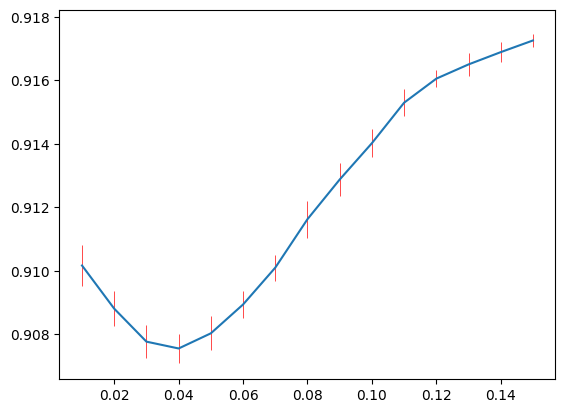

In [10]:
parameter_tuning.plot_error_1d(val_err_l2.squeeze(), lambda_lst=l2_list)

In [11]:
val_avg = np.mean(val_err_l2, axis=0)
l2_est = l2_list[np.argmin(val_avg)]
print(l2_est)

0.04


We can also use the one standard error rule.

In [12]:
parameter_tuning.get_lambda_one_se_1d(val_err_l2.squeeze(), l2_list)

0.05

## Alternative: use grid search for two hyperparameters

As discussed above, we can use 2D grid search for different combinations of $\lambda_1$ and $\lambda_2$.
This will usually take long time, and is not recommended unless the network (node number and sample size) is small.

In [13]:
RUN_ME = False

if RUN_ME:
    l1_list = np.arange(0.02, 0.401, 0.02)
    l2_list = np.arange(0.01, 0.16, 0.01)
    val_err_2d = parameter_tuning.cv_2d(
        dat1,
        dat2,
        n_cv=5,
        ratio_val=0.5, 
        lambda1_lst=l1_list,
        lambda2_lst=l2_list,
        dep_mat=dep_mat,
        cores=cores,
    )
    parameter_tuning.plot_error_2d(val_err_2d)

## Alternative: use statistical approaches

We can also estimate $\lambda_1$ and $\lambda_2$ based on some statistics of the data.
More details can be found in the DDN3.0 paper. Usually, these estimates are not accurate enough, and we suggest the above cross validation protocol.

In [14]:
n = int((len(dat1) + len(dat2))/2)
p = dat1.shape[1]
alpha1 = 0.05
alpha2 = 0.01

# using the method in the M-B algorithm to estimate lambda1
l1_est = parameter_tuning.get_lambda1_mb(alpha1, n, p, mthd=0)

# using Bai's method in the UAI paper to estimate lambda2
l2_est = parameter_tuning.get_lambda2_bai(dat1, dat2, alpha=alpha2)

print(l1_est, l2_est)

0.2711602723929704 0.08082354445935315
